# Image Classification using AWS Sagemaker


In this project, we will use the Dog Breeds dataset provided by Udacity. The dataset contains 133 kinds of dog breeds. This project will make use of deep learning concept of Machine Learning and also use the pretrained Resnet34 model from pytorch vision. This model will classify the images of the dogs based on their breeds.

In [2]:
# installing packages
!pip install smdebug

In [2]:
!pip install torch --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils 

In [3]:
# importing packages
import sagemaker
import boto3
import os
from sagemaker.pytorch import PyTorch
import torch

## Dataset

In this project I have used the DogImages dataset of AWS. This dataset contains images of several dog breeds. The "dogImages" dataset contains three sections for data training, testing and validation. Each group has all the dog breeds and their respective images in each folder.

In [4]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"

In [5]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-02-04 06:50:39--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.104
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  45.8MB/s    in 32s     

2022-02-04 06:51:14 (33.3 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [ ]:
# use default S3 bucket
bucket = sagemaker_session.default_bucket()

import os
# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-243972071013/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg to s3://sagemaker-us-east-1-243972071013/dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://sagemaker-us-east-1-243972071013/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00141.jpg to s3://sagemaker-us-east-1-243972071013/dogImages/test/002.Afghan_hound/Afghan_hound_00141.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-243972071013/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg to s3://sagemaker-us-east-1-243972071013/dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg
upload: dogImages/test/001.Affenpi

## Hyperparameter Tuning
**TODO:** This is the part where wewill finetune a pretrained model with hyperparameter tuning. We will tune *Learning Rate* and *Batchsize*.

**Note:** We will need to use the `hpo.py` script to perform hyperparameter tuning.

In [8]:
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256])
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [9]:
# Creating estimators for Hyperparameter tuning jobs

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name = 'hpo_tuning_dog_breed',
    role=role,
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
    )


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [10]:
# assigning S3 paths for the training job
s3_data = "s3://{}/{}/".format(bucket, "dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= s3_data
os.environ['SM_MODEL_DIR']= s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

In [11]:
# Fit the HP Tuner with input data channel

tuner.fit({'train' : s3_data},wait=True) 

.......................................................................................................................................................................................!


In [12]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

# Getting the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-02-04 07:40:10 Starting - Preparing the instances for training
2022-02-04 07:40:10 Downloading - Downloading input data
2022-02-04 07:40:10 Training - Training image download completed. Training in progress.
2022-02-04 07:40:10 Uploading - Uploading generated training model
2022-02-04 07:40:10 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'lr': '0.0024652251714435717',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_tuning_dog_breed-2022-02-04-07-26-06-494"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-243972071013/hpo_tuning_dog_breed-2022-02-04-07-26-06-494/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Note:** We will need to use the `train_model.py` script to perform model profiling and debugging.

In [13]:
# Setting up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [14]:
# Create and fit an estimator with best parameters

hyperparameters = {"batch_size": "32", "lr": "0.0013439939513439198"} # Training with best parameters
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : s3_data},wait=True)

2022-02-04 07:41:56 Starting - Starting the training job...
2022-02-04 07:42:24 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-02-04 07:43:24 Starting - Preparing the instances for training......
2022-02-04 07:44:24 Downloading - Downloading input data............
2022-02-04 07:46:27 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-04 07:46:28,686 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-02-04 07:46:28,710 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-04 07:46:31,723 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-04 07:46:32,027 sagemaker-containers INFO     Module defa

In [15]:
# Plot a debugging output.

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))


Training jobname: pytorch-training-2022-02-04-07-41-56-070
Region: us-east-1
[2022-02-04 07:49:14.648 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:42 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-04 07:49:14.684 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:42 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-243972071013/pytorch-training-2022-02-04-07-41-56-070/debug-output
[2022-02-04 07:49:17.820 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:42 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-04 07:49:18.845 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:42 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'gradient/ResNet_fc.4.bias', 'gradient/ResNet_fc.4.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'lay

In [17]:
tensor_name = "CrossEntropyLoss_output_0"

In [18]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [19]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200],
 [array(4.946729, dtype=float32),
  array(4.90918, dtype=float32),
  array(4.776817, dtype=float32),
  array(4.3703938, dtype=float32),
  array(4.4184985, dtype=float32),
  array(4.0361013, dtype=float32),
  array(3.7159035, dtype=float32),
  array(3.6467226, dtype=float32),
  array(3.3369787, dtype=float32),
  array(2.7082999, dtype=float32),
  array(2.6243587, dtype=float32),
  array(2.3325624, dtype=float32),
  array(2.3181598, dtype=float32),
  array(2.5582392, dtype=float32),
  array(2.494144, dtype=float32),
  array(1.791509, dtype=float32),
  array(1.6873795, dtype=float32),
  array(1.7760667, dtype=float32),
  array(1.9009624, dtype=float32),
  array(2.0363169, dtype=float32),
  array(1.6004183, dtype=float32)])

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


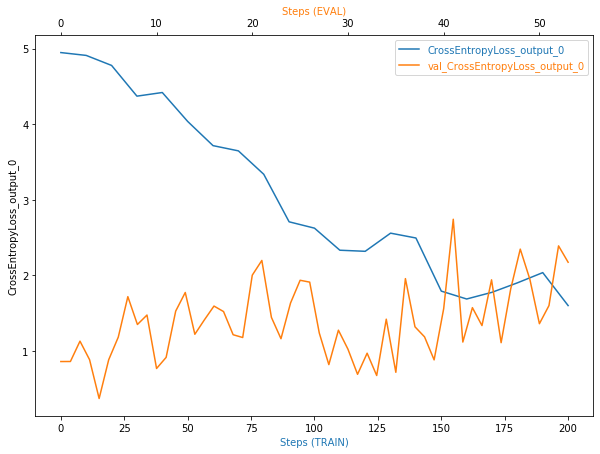

In [22]:
plot_tensor(trial, "CrossEntropyLoss_output_0") #Plotting the loss

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

The line for "CrossEntropyLoss_output_0" and "val_CrossEntropyLoss_output_0" should have been smooth. This anomalous behaviour can be rectified by adjusting the pretrained model.

In [23]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-243972071013/pytorch-training-2022-02-04-07-41-56-070/rule-output


In [24]:
! aws s3 ls {rule_output_path} --recursive

2022-02-04 07:48:40     335928 pytorch-training-2022-02-04-07-41-56-070/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-04 07:48:40     178320 pytorch-training-2022-02-04-07-41-56-070/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-04 07:48:36        191 pytorch-training-2022-02-04-07-41-56-070/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-04 07:48:36       6768 pytorch-training-2022-02-04-07-41-56-070/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-04 07:48:36        126 pytorch-training-2022-02-04-07-41-56-070/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-04 07:48:36        129 pytorch-training-2022-02-04-07-41-56-070/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-04 07:48:36       3435 pytorch-training-2022-02-04-07-41-56-070/rule-output/ProfilerReport/profiler-output/profiler-re

In [25]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-243972071013/pytorch-training-2022-02-04-07-41-56-070/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-243972071013/pytorch-training-2022-02-04-07-41-56-070/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-243972071013/pytorch-training-2022-02-04-07-41-56-070/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-243972071013/pytorch-training-2022-02-04-07-41-56-070/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-

In [26]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [27]:
import IPython
# output the profiler report
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

Model raised an error when deployed normally. So I took reference from (https://github.com/htinaunglu/DogBreed-Classification-With-Amazon-Sagemaker) to solve that error

In [28]:
model_location=estimator.model_data

In [29]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [30]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [31]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='endpoint.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor) 

In [32]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

--------!

In [36]:
!ls

CODEOWNERS	README.md   dogImages.zip  train_and_deploy.ipynb
LICENSE.txt	demo.ipynb  endpoint.py    train_model.py
ProfilerReport	dogImages   hpo.py


In [37]:
with open("dogImages/test/004.Akita/Akita_00244.jpg", "rb") as f:
    payload = f.read()
        
type(payload)

bytes

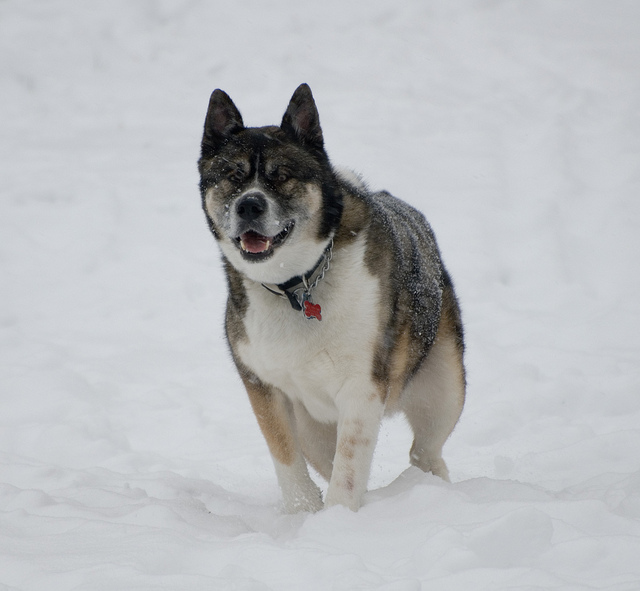

In [38]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [39]:
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response

[[-14.815505027770996,
  -9.531896591186523,
  -5.181740760803223,
  2.3826539516448975,
  3.9258739948272705,
  -3.3489770889282227,
  -3.623007297515869,
  -2.2175910472869873,
  -10.115772247314453,
  -1.3125733137130737,
  3.186084032058716,
  -2.059767007827759,
  -9.917221069335938,
  -2.680448293685913,
  -8.208232879638672,
  -1.1006590127944946,
  -9.82380199432373,
  -4.481400012969971,
  -3.8395118713378906,
  0.727883517742157,
  -4.305592060089111,
  0.374907910823822,
  -7.014841079711914,
  -9.082358360290527,
  -14.105010032653809,
  -13.214815139770508,
  -9.083625793457031,
  -8.442438125610352,
  -4.68231725692749,
  -3.961341619491577,
  -5.174928188323975,
  -8.250351905822754,
  -12.557621955871582,
  -7.75197696685791,
  -16.512643814086914,
  -12.083514213562012,
  -6.462535381317139,
  -11.30802059173584,
  -4.564601421356201,
  -8.772659301757812,
  -9.556504249572754,
  -7.2789411544799805,
  2.5442306995391846,
  -7.697515487670898,
  2.037238597869873,
  -1

In [40]:
import torch
import numpy as np
np.argmax(response, 1)

array([4])

It is Akita!! Prediction was correct

In [41]:
# delete the endpoint once work is done as it charges overtime
predictor.delete_endpoint()